In [51]:
import cv2
import matplotlib.pyplot as plt
import re
import json
import collections
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.utils import to_categorical
from keras.layers import *
import numpy as np
from time import time
import pickle
from keras.models import load_model

## Data Collection

In [2]:
def readTextFile(path):
    
    with open(path) as f:
        captions = f.read()
    return captions

In [3]:
captions = readTextFile("flickr8k/Flickr_Data/Flickr_TextData/Flickr8k.token.txt")
captions = captions.split("\n")[:-1]
print(captions[0])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .


In [4]:
discriptions = {}

for c in captions:
    
    first, second = c.split("\t")
    img_id = first.split(".")[0]
    
    if discriptions.get(img_id) is None:
        discriptions[img_id] = []
    
    discriptions[img_id].append(second)

In [5]:
discriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

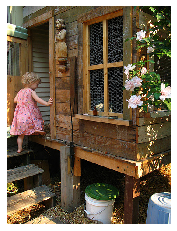

In [6]:
img_path = "flickr8k/Flickr_Data/Images/"
img = cv2.imread(img_path+"1000268201_693b08cb0e.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

## Data Cleaning

In [7]:
def clean_text(sent):
    
    sent = sent.lower()
    sent = re.sub("[^a-z]+", " ", sent)
    sent = sent.split()
    sent = [s for s in sent if len(s)>1]
    sent = " ".join(sent)
    
    return sent

In [8]:
for id_, captions in discriptions.items():
    for i in range(len(captions)):
        captions[i] = clean_text(captions[i])

In [9]:
with open("discriptions_1.txt","w") as f:
    f.write(str(discriptions))

## Vocabulary

In [10]:
discriptions = None

with open("discriptions_1.txt", "r") as f:
    discriptions = f.read()

json_acc_format = discriptions.replace("'", "\"")
discriptions = json.loads(json_acc_format)

In [11]:
discriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [12]:
#vocab
vocab = set()

for key in discriptions.keys():
    [vocab.update(sent.split()) for sent in discriptions[key]]
    
print(len(vocab))

8424


In [13]:
# total words across each caption
total_words = []

for key in discriptions.keys():
    [total_words.append(i) for cap in discriptions[key] for i in cap.split()]

print(len(total_words))

373837


In [14]:
count = collections.Counter(total_words)
freq = dict(count)
sorted_freq = sorted(freq.items(), reverse=True, key=lambda x:x[1])

# list of words which have frequency more than threshold

threshold = 10
sorted_freq = [x for x in sorted_freq if x[1]>threshold]
total_words = [x[0] for x in sorted_freq]

print(len(total_words))

1845


## Preparing train/test data

In [15]:
train = readTextFile("flickr8k/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test = readTextFile("flickr8k/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [16]:
train = [img_id.split(".")[0] for img_id in train.split("\n")[:-1]]
test = [img_id.split(".")[0] for img_id in test.split("\n")[:-1]]

In [17]:
# prepare discription for our training data
# tweak - add <s> and <e> to token to training data

train_discriptions = {}

for img_id in train:
    
    train_discriptions[img_id] = []
    
    for cap in discriptions[img_id]:
    
        cap = "<s> " + cap + " <e>"
        train_discriptions[img_id].append(cap)
        
print(train_discriptions["1000268201_693b08cb0e"])

['<s> child in pink dress is climbing up set of stairs in an entry way <e>', '<s> girl going into wooden building <e>', '<s> little girl climbing into wooden playhouse <e>', '<s> little girl climbing the stairs to her playhouse <e>', '<s> little girl in pink dress going into wooden cabin <e>']


## Transfer Learning

In [18]:
# Images->features

model = ResNet50(weights='imagenet', input_shape=(224, 224, 3))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
_____________________________________

In [19]:
model_new = Model(model.input, model.layers[-2].output)

In [20]:
def img_preprocess(img):
    img = image.load_img(img, target_size=(224, 224))  
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    # Normalization
    img = preprocess_input(img)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


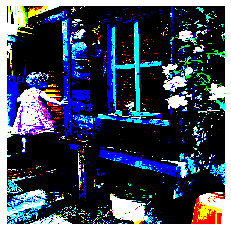

[[[[ -30.939003   -61.779      -67.68     ]
   [  13.060997     6.2210007  -17.68     ]
   [  34.060997    32.221        5.3199997]
   ...
   [ -99.939     -116.779     -118.68     ]
   [ -98.939     -111.779     -118.68     ]
   [-101.939     -108.779     -120.68     ]]

  [[ -36.939003   -68.779      -72.68     ]
   [  21.060997     9.221001   -13.68     ]
   [  38.060997    37.221        8.32     ]
   ...
   [ -94.939     -104.779     -113.68     ]
   [ -93.939     -108.779     -116.68     ]
   [ -90.939      -86.779     -102.68     ]]

  [[ -39.939003   -74.779      -76.68     ]
   [  26.060997    13.221001    -9.68     ]
   [  41.060997    36.221        6.3199997]
   ...
   [ -99.939     -107.779     -115.68     ]
   [-101.939     -107.779     -121.68     ]
   [ -95.939     -101.779     -123.68     ]]

  ...

  [[ -27.939003    56.221      107.32     ]
   [ -92.939      -49.779       20.32     ]
   [ -49.939003   -13.778999    35.32     ]
   ...
   [ 150.061      132.22101    126.

In [21]:
# img = cv2.imread(img_path+"1000268201_693b08cb0e.jpg")
img = img_preprocess(img_path+"1000268201_693b08cb0e.jpg")
plt.imshow(img[0])
plt.axis('off')
plt.show()
print(img)

In [22]:
def encode_img(img):
    img = img_preprocess(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape((-1,))
#     print(feature_vector.shape)
    return feature_vector

In [23]:
encode_img(img_path+"1000268201_693b08cb0e.jpg")

array([0.04154494, 0.1707585 , 0.29276794, ..., 0.05094048, 0.31319588,
       0.86007315], dtype=float32)

In [24]:
start_t = time()
encoded_train_imgs = {}

for ix, img_id in enumerate(train):
    img = img_path + img_id + ".jpg"
    encoded_train_imgs[img_id] = encode_img(img)
    
    if ix%100==0:
        print("Encoding in progress time step %d"%ix)

end_t = time()
print("Total time taken :",end_t-start_t)


Encoding in progress time step 0
Encoding in progress time step 100
Encoding in progress time step 200
Encoding in progress time step 300
Encoding in progress time step 400
Encoding in progress time step 500
Encoding in progress time step 600
Encoding in progress time step 700
Encoding in progress time step 800
Encoding in progress time step 900
Encoding in progress time step 1000
Encoding in progress time step 1100
Encoding in progress time step 1200
Encoding in progress time step 1300
Encoding in progress time step 1400
Encoding in progress time step 1500
Encoding in progress time step 1600
Encoding in progress time step 1700
Encoding in progress time step 1800
Encoding in progress time step 1900
Encoding in progress time step 2000
Encoding in progress time step 2100
Encoding in progress time step 2200
Encoding in progress time step 2300
Encoding in progress time step 2400
Encoding in progress time step 2500
Encoding in progress time step 2600
Encoding in progress time step 2700
Enco

In [25]:
# Store encodings in pkl 
with open("encoded_train_features.pkl", "wb") as f:
    pickle.dump(encoded_train_imgs, f)

In [26]:
# Encoding images for test
start_t = time()
encoded_test_imgs = {}

for ix, img_id in enumerate(test):
    img = img_path + img_id + ".jpg"
    encoded_test_imgs[img_id] = encode_img(img)
    
    if ix%100==0:
        print("Encoding in progress time step for test %d"%ix)

end_t = time()
print("Total time taken :",end_t-start_t)

Encoding in progress time step for test 0
Encoding in progress time step for test 100
Encoding in progress time step for test 200
Encoding in progress time step for test 300
Encoding in progress time step for test 400
Encoding in progress time step for test 500
Encoding in progress time step for test 600
Encoding in progress time step for test 700
Encoding in progress time step for test 800
Encoding in progress time step for test 900
Total time taken : 36.91442584991455


In [27]:
# Store encodings in pkl 
with open("encoded_test_features.pkl", "wb") as f:
    pickle.dump(encoded_train_imgs, f)

### Caption Preprocessing

In [28]:
word_to_idx = {}
idx_to_word = {}

for i, word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

print(idx_to_word[1])
print(word_to_idx["in"])
print(len(word_to_idx))

in
1
1845


In [29]:
word_to_idx["<s>"] = 1846
idx_to_word[1846] = "<s>"

word_to_idx["<e>"] = 1847
idx_to_word[1847] = "<e>"

vocab_size = len(word_to_idx)+1

In [30]:
max_len = 0
for key in train_discriptions.keys():
    for cap in train_discriptions[key]:
        max_len = max(max_len, len(cap.split()))
        
print(max_len)

35


## Data Loader(Generator)

In [31]:
def data_generatot(train_discriptions, encoded_train_imgs, word_to_idx, max_len, batch_size):
    
    X1, X2, y = [], [], []
    
    n = 0
    while(True):
    
        for key, caps in train_discriptions.items():
            
            n+=1
            img_id = encoded_train_imgs[key]
            
            for c in caps:
                seq = [word_to_idx[word] for word in c.split() if word in word_to_idx]
                
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    xi = pad_sequences([xi], max_len, value=0, padding='post')[0]
                    yi = to_categorical([yi], num_classes=vocab_size)[0]
                    
                    X1.append(img_id)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield[[np.array(X1), np.array(X2)], np.array(y)]
                    X1, X2, y = [], [], []
                    n = 0

## Word embeddings

In [32]:
f = open("glove6b50dtxt/glove.6B.50d.txt")

In [33]:
embedded_list = {}

for line in f:
    
    values = line.split()
    temp_embedding = np.array(values[1:])
    embedded_list[values[0]] = temp_embedding


In [36]:
def word_embeddings():
    
    emb_dims = 50
    matrix = np.zeros((vocab_size, emb_dims))
    for word, idx in word_to_idx.items():
        
        embedding_vector = embedded_list.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
    
    return matrix

In [37]:
embedded_matrix = word_embeddings()
print(embedded_matrix.shape)

(1848, 50)


## Model Architechture

In [39]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(.3)(input_img_features)
inp_img2 = Dense(256, activation='relu')(inp_img1)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [40]:
input_caps = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(input_caps)
inp_cap2 = Dropout(.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [41]:
decoder1 = add([inp_img2, inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
decoder3 = Dense(vocab_size, activation='softmax')(decoder2)

# Combined Models
model = Model(inputs=[input_img_features, input_caps], outputs=decoder3)

model.summary()

In [42]:
model.layers[2].set_weights([embedded_matrix])
model.layers[2].trainable = False

In [43]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

## Training Model

In [47]:
epochs = 20
batch_size = 3
steps = len(train_discriptions)//batch_size

def Train():
    
    for i in range(epochs):
        
        generator = data_generatot(train_discriptions, encoded_train_imgs, word_to_idx, max_len, batch_size)
        model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
        model.save("./model_weights/model_"+str(i)+".h5")

In [52]:
model = load_model("./model_weights/model_9.h5")

## Predictions

In [62]:
def predict_caption(image):
    
    in_text = "<s>"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')
    
        ypred = model.predict([image, sequence])
        ypred = ypred.argmax()
        
        word = idx_to_word[ypred]
        in_text += (" " + word)
        
        if word=="<e>":
            break
            
    final_cap = in_text.split()[1:-1]
    final_cap = " ".join(final_cap)
        
    return final_cap

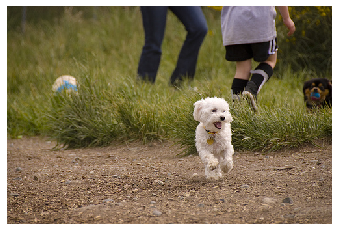

two dogs are playing in field


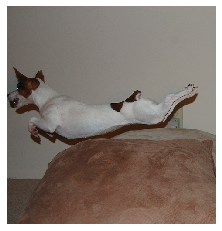

two dogs are playing with each other on the floor


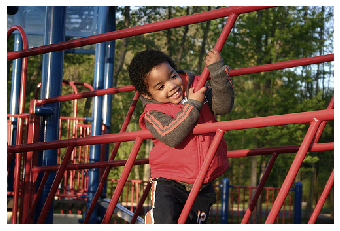

little girl in blue shirt is jumping on swing set


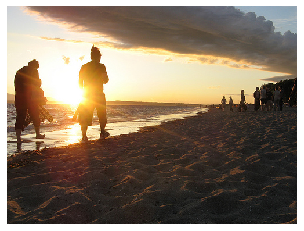

people are enjoying their arms in the air


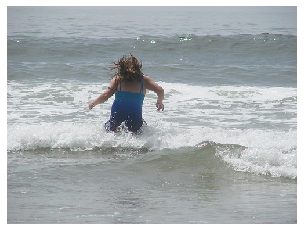

young boy in blue wetsuit is running through the ocean


In [65]:
for i in range(5):
    
    idx = np.random.randint(0,1000)
    all_img_names = list(encoded_test_imgs.keys())
    img_name = all_img_names[idx]
    img_2048 = encoded_test_imgs[img_name].reshape((1,2048))
    
    i = plt.imread(img_path+img_name+".jpg")
    caption = predict_caption(img_2048)
    plt.imshow(i)
    plt.axis('off')
    plt.show()
    print(caption)